In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import string

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, concatenate, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold, cross_val_score

##ML scikit learn classes for model selection:  
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [3]:
### Label Encoding, Removing Zero variance Features and Scaling the test data::
def initial(df):
    
    #### Label Encoding the Target Variable
    X=df.drop(["label"],axis=1)
    y=df["label"]
    if df.label.dtype=="O":   ### Will apply label encoding if needed
        le=LabelEncoder()
        y=le.fit_transform(y)
        y=pd.Series(y)

    #### Removing Features having zero variance.

    Var=X[X.columns].std()
    col=Var[Var==0].index
    X=X.drop(col,axis=1)
    
    return X,y

In [4]:
def preprocess():
  ### For the best model using EMG and NEMG Features (EMG+NEMG Combined)
  df_emg=pd.read_csv("/content/drive/MyDrive/HAR Datasets/EMG_ANOVA_300_features.csv").rename({'0':'label'},axis=1)
  df_nemg=pd.read_csv("/content/drive/MyDrive/HAR Datasets/IMU_ANOVA_300_features.csv").rename({"0":"label"},axis=1)

  # temp=pd.DataFrame()
  # for i in range(26):
  #     n=df_nemg[df_nemg["label"]==i].reset_index(drop=True)
  #     e=df_emg[df_emg["label"]==i].reset_index(drop=True).drop(["label"],axis=1)[0:n.shape[0]]
  #     k=pd.concat([e,n],axis=1)
  #     temp=pd.concat([temp,k],axis=0)   

  X1,y1=initial(df_emg) 
  X2,y2=initial(df_nemg)

  l1=list(df_emg.columns[:-1])
  l2=list(df_nemg.columns[:-1])

  ## Splitting the EMG data:
  X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,stratify=y1,test_size=0.15, random_state=2)
  sc=StandardScaler()
  X_train1=sc.fit_transform(X_train1)
  X_train1=pd.DataFrame(X_train1,columns=l1)
  X_test1=sc.transform(X_test1)
  X_test1=pd.DataFrame(X_test1,columns=l1)

  ## Splitting the IMU data:
  X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y1,stratify=y1,test_size=0.15, random_state=2)
  sc=StandardScaler()
  X_train2=sc.fit_transform(X_train2)
  X_train2=pd.DataFrame(X_train2,columns=l2)
  X_test2=sc.transform(X_test2)
  X_test2=pd.DataFrame(X_test2,columns=l2)

  m=min(X1.shape[0],X2.shape[0])

  return X1.iloc[:m,:],X2.iloc[:m,:]

In [5]:
## Model Building:
class model:
  def __init__(self,emg_shape,imu_shape,decoder=False):
    # Define the input shape for each sensor feature
    input_shape1 = (emg_shape,)  # Sensor 1 has 100 features
    input_shape2 = (imu_shape,)   # Sensor 2 has 50 features

    # Define the first encoder layer for each sensor input
    input_layer1 = Input(shape=input_shape1)
    hidden_layer1_1 = Dense(300, activation='relu')(input_layer1)

    input_layer2 = Input(shape=input_shape2)
    hidden_layer2_1 = Dense(300, activation='relu')(input_layer2)

    # Define the second encoder layer for each sensor input
    hidden_layer1_2 = Dense(150, activation='relu')(hidden_layer1_1)
    hidden_layer2_2 = Dense(150, activation='relu')(hidden_layer2_1)

    # Combine the encoder outputs from each sensor input
    merged_encoder_output = concatenate([hidden_layer1_2, hidden_layer2_2], axis=-1)
    
    if decoder==True:
      # Define the shared decoder layers
      hidden_layer3 = Dense(150, activation='relu')(merged_encoder_output)
      hidden_layer4 = Dense(150, activation='relu')(hidden_layer3)

      # Define the decoder layer for each sensor input
      output_layer1 = Dense(emg_shape, activation='sigmoid')(hidden_layer4)
      output_layer2 = Dense(imu_shape, activation='sigmoid')(hidden_layer4)

      # Define the autoencoder model with multiple inputs and outputs
      self.autoencoder = tf.keras.models.Model(inputs=[input_layer1, input_layer2], outputs=[output_layer1, output_layer2])
    else:
      self.autoencoder = tf.keras.models.Model(inputs=[input_layer1, input_layer2], outputs=merged_encoder_output)

  def model_config(self):
    self.autoencoder.compile(optimizer=Adam(lr=0.001),metrics='accuracy',loss='mse')
    return self.autoencoder

In [6]:
def lc(path,loss,val_loss):
  plt.figure(figsize=(10,10))
  plt.plot(loss,c= 'b',label="train_loss")
  plt.plot(val_loss,c= 'r',label="val_loss")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig(f"{path}/learning_curve.png")

In [7]:
def train(path,X1,X2):
  if os.path.exists(f'{path}') == False:
    os.mkdir(f'{path}')

  #---
  sc1=StandardScaler()
  X1=sc1.fit_transform(X1)
  #---
  sc2=StandardScaler()
  X2=sc2.fit_transform(X2)

  n_split=5
  sf=KFold(n_split)
  emg=list(sf.split(X1))
  imu=list(sf.split(X2))
  results={}

  for i in range(n_split):
    autoencoder=model(X1.shape[1],X2.shape[1],True).model_config()
    history = autoencoder.fit([X1[[emg[i][0]]],X2[[imu[i][0]]]], [X1[[emg[i][0]]],X2[[imu[i][0]]]], epochs=100, batch_size=50,
                                  validation_data=([X1[[emg[i][1]]],X2[[imu[i][1]]]],[X1[[emg[i][1]]],X2[[imu[i][1]]]]))

    lc(path,history.history["loss"],history.history["val_loss"])
    # results[f"Fold {i+1}"]={"output_imu_accuracy":max(history.history['output_imu_accuracy']),
    #                   "val_output_imu_accuracy":max(history.history['val_output_imu_accuracy']),
    #                   "output_emg_accuracy":max(history.history['output_emg_accuracy']),
    #                   "val_output_emg_accuracy":max(history.history['val_output_emg_accuracy'])}

  with open(f'{path}/results.json', 'w') as fp:
    json.dump(results, fp,  indent=4)
  encoder=model(X1.shape[1],X2.shape[1],False).model_config()
  encoder.save(f"{path}/model.h5")

In [8]:
## For getting transformed using autoencoder::
def transform_data():
  ### For the best model using EMG and NEMG Features (EMG+NEMG Combined)
  df_emg=pd.read_csv("/content/drive/MyDrive/HAR Datasets/EMG_ANOVA_300_features.csv").rename({'0':'label'},axis=1)
  df_nemg=pd.read_csv("/content/drive/MyDrive/HAR Datasets/IMU_ANOVA_300_features.csv").rename({"0":"label"},axis=1)

  imu=pd.DataFrame()
  emg=pd.DataFrame()
  for i in string.ascii_uppercase:
      n=df_nemg[df_nemg["label"]==i].reset_index(drop=True)
      e=df_emg[df_emg["label"]==i].reset_index(drop=True)[0:n.shape[0]]
      emg=emg.append(e,ignore_index=True)
      imu=imu.append(n,ignore_index=True)
  
  X1,y1=initial(emg) 
  X2,y2=initial(imu)

  # m=min(X1.shape[0],X2.shape[0])

  return X1,X2,y1,y2

In [11]:
def training(path):
  ## Loading the encoder:
  encoder = tf.keras.models.load_model(path+"/model.h5")

  X1,X2,y1,y2=transform_data()

  ## Created the new dataset for classification:
  X=encoder.predict([X1,X2])
  y=y1
  
  ## Splitting and Scaling:
  df=pd.DataFrame(X,columns=[f"i" for i in range(X.shape[1])])
  df=pd.concat([df,y],axis=1)
  df.rename(columns={0:"label"},inplace=True)
  # X_train,X_test,y_train,y_test=train_test_split(df.iloc[:,:-1],df.iloc[:,-1],stratify=df.iloc[:,-1],random_state=42)

  sc = StandardScaler()
  X = sc.fit_transform(df.iloc[:,:-1].values)
  y=df.iloc[:,-1].values
  # X_test = sc.transform(X_test)

  ## Setting up the models:
  models={"XGB":XGBClassifier(),"LGBM":LGBMClassifier(),"GradientBoost":GradientBoostingClassifier(),"LDA":LinearDiscriminantAnalysis(),"RandomForest":RandomForestClassifier()}
  res={}

  ## Applying cross-validation and saving the results:
  for i,j in models.items():
    acc=cross_val_score(j,X,y,cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
    res[i]=acc.mean()
  
  with open(f'{path}/results.json', 'w') as fp:
    json.dump(res, fp,  indent=4)


<ipython-input-7-13442978c30b>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  history = autoencoder.fit([X1[[emg[i][0]]],X2[[imu[i][0]]]], [X1[[emg[i][0]]],X2[[imu[i][0]]]], epochs=100, batch_size=50,
<ipython-input-7-13442978c30b>:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  validation_data=([X1[[emg[i][1]]],X2[[imu[i][1]]]],[X1[[emg[i][1]]],X2[[imu[i][1]]]]))


Epoch 1/100
379/379 [==============================] - 5s 8ms/step - loss: 1.5906 - dense_14_loss: 0.8650 - dense_15_loss: 0.7256 - dense_14_accuracy: 0.0171 - dense_15_accuracy: 0.0102 - val_loss: 0.8990 - val_dense_14_loss: 0.5098 - val_dense_15_loss: 0.3892 - val_dense_14_accuracy: 0.0116 - val_dense_15_accuracy: 0.0412
Epoch 2/100
379/379 [==============================] - 2s 5ms/step - loss: 1.3813 - dense_14_loss: 0.7519 - dense_15_loss: 0.6294 - dense_14_accuracy: 0.0280 - dense_15_accuracy: 0.0636 - val_loss: 0.8414 - val_dense_14_loss: 0.4740 - val_dense_15_loss: 0.3673 - val_dense_14_accuracy: 0.0027 - val_dense_15_accuracy: 0.0851
Epoch 3/100
379/379 [==============================] - 2s 5ms/step - loss: 1.3573 - dense_14_loss: 0.7419 - dense_15_loss: 0.6154 - dense_14_accuracy: 0.0365 - dense_15_accuracy: 0.0821 - val_loss: 0.8105 - val_dense_14_loss: 0.4536 - val_dense_15_loss: 0.3570 - val_dense_14_accuracy: 0.0065 - val_dense_15_accuracy: 0.0893
Epoch 4/100
379/379 [====

Epoch 1/100
379/379 [==============================] - 5s 8ms/step - loss: 1.4096 - dense_22_loss: 0.7728 - dense_23_loss: 0.6368 - dense_22_accuracy: 0.0287 - dense_23_accuracy: 0.0166 - val_loss: 1.4517 - val_dense_22_loss: 0.7914 - val_dense_23_loss: 0.6603 - val_dense_22_accuracy: 0.0133 - val_dense_23_accuracy: 0.0781
Epoch 2/100
379/379 [==============================] - 2s 5ms/step - loss: 1.2199 - dense_22_loss: 0.6752 - dense_23_loss: 0.5447 - dense_22_accuracy: 0.0460 - dense_23_accuracy: 0.0464 - val_loss: 1.4253 - val_dense_22_loss: 0.7731 - val_dense_23_loss: 0.6522 - val_dense_22_accuracy: 0.0239 - val_dense_23_accuracy: 0.0990
Epoch 3/100
379/379 [==============================] - 2s 5ms/step - loss: 1.2085 - dense_22_loss: 0.6673 - dense_23_loss: 0.5412 - dense_22_accuracy: 0.0596 - dense_23_accuracy: 0.0714 - val_loss: 1.4171 - val_dense_22_loss: 0.7676 - val_dense_23_loss: 0.6495 - val_dense_22_accuracy: 0.0268 - val_dense_23_accuracy: 0.1079
Epoch 4/100
379/379 [====

Epoch 1/100
379/379 [==============================] - 4s 5ms/step - loss: 1.3979 - dense_30_loss: 0.7256 - dense_31_loss: 0.6723 - dense_30_accuracy: 0.0306 - dense_31_accuracy: 0.0280 - val_loss: 1.5428 - val_dense_30_loss: 0.9059 - val_dense_31_loss: 0.6370 - val_dense_30_accuracy: 0.0175 - val_dense_31_accuracy: 6.3345e-04
Epoch 2/100
379/379 [==============================] - 2s 5ms/step - loss: 1.2267 - dense_30_loss: 0.6348 - dense_31_loss: 0.5919 - dense_30_accuracy: 0.0496 - dense_31_accuracy: 0.0781 - val_loss: 1.4942 - val_dense_30_loss: 0.8689 - val_dense_31_loss: 0.6253 - val_dense_30_accuracy: 0.0055 - val_dense_31_accuracy: 0.0135
Epoch 3/100
379/379 [==============================] - 3s 7ms/step - loss: 1.2075 - dense_30_loss: 0.6237 - dense_31_loss: 0.5838 - dense_30_accuracy: 0.0586 - dense_31_accuracy: 0.0852 - val_loss: 1.4553 - val_dense_30_loss: 0.8548 - val_dense_31_loss: 0.6005 - val_dense_30_accuracy: 0.0082 - val_dense_31_accuracy: 0.0494
Epoch 4/100
379/379 [

Epoch 1/100
379/379 [==============================] - 4s 5ms/step - loss: 1.4291 - dense_38_loss: 0.8012 - dense_39_loss: 0.6280 - dense_38_accuracy: 0.0490 - dense_39_accuracy: 0.0182 - val_loss: 1.4381 - val_dense_38_loss: 0.6435 - val_dense_39_loss: 0.7947 - val_dense_38_accuracy: 0.0186 - val_dense_39_accuracy: 0.0059
Epoch 2/100
379/379 [==============================] - 2s 5ms/step - loss: 1.2245 - dense_38_loss: 0.6924 - dense_39_loss: 0.5321 - dense_38_accuracy: 0.0637 - dense_39_accuracy: 0.0808 - val_loss: 1.3269 - val_dense_38_loss: 0.6063 - val_dense_39_loss: 0.7206 - val_dense_38_accuracy: 0.0300 - val_dense_39_accuracy: 0.0477
Epoch 3/100
379/379 [==============================] - 2s 5ms/step - loss: 1.2116 - dense_38_loss: 0.6852 - dense_39_loss: 0.5264 - dense_38_accuracy: 0.0797 - dense_39_accuracy: 0.1158 - val_loss: 1.3134 - val_dense_38_loss: 0.5954 - val_dense_39_loss: 0.7181 - val_dense_38_accuracy: 0.0325 - val_dense_39_accuracy: 0.0777
Epoch 4/100
379/379 [====

Epoch 1/100
379/379 [==============================] - 4s 5ms/step - loss: 1.3822 - dense_46_loss: 0.7298 - dense_47_loss: 0.6524 - dense_46_accuracy: 0.0570 - dense_47_accuracy: 0.0177 - val_loss: 1.5684 - val_dense_46_loss: 0.9290 - val_dense_47_loss: 0.6394 - val_dense_46_accuracy: 0.0030 - val_dense_47_accuracy: 0.0068
Epoch 2/100
379/379 [==============================] - 2s 5ms/step - loss: 1.1966 - dense_46_loss: 0.6280 - dense_47_loss: 0.5686 - dense_46_accuracy: 0.0886 - dense_47_accuracy: 0.0563 - val_loss: 1.5188 - val_dense_46_loss: 0.8790 - val_dense_47_loss: 0.6398 - val_dense_46_accuracy: 0.0089 - val_dense_47_accuracy: 0.0080
Epoch 3/100
379/379 [==============================] - 2s 5ms/step - loss: 1.1816 - dense_46_loss: 0.6164 - dense_47_loss: 0.5653 - dense_46_accuracy: 0.1141 - dense_47_accuracy: 0.0659 - val_loss: 1.5053 - val_dense_46_loss: 0.8652 - val_dense_47_loss: 0.6401 - val_dense_46_accuracy: 0.0171 - val_dense_47_accuracy: 0.0173
Epoch 4/100
379/379 [====

<ipython-input-8-5e44927d5129>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emg=emg.append(e,ignore_index=True)
<ipython-input-8-5e44927d5129>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imu=imu.append(n,ignore_index=True)


740/740 [==============================] - 2s 2ms/step


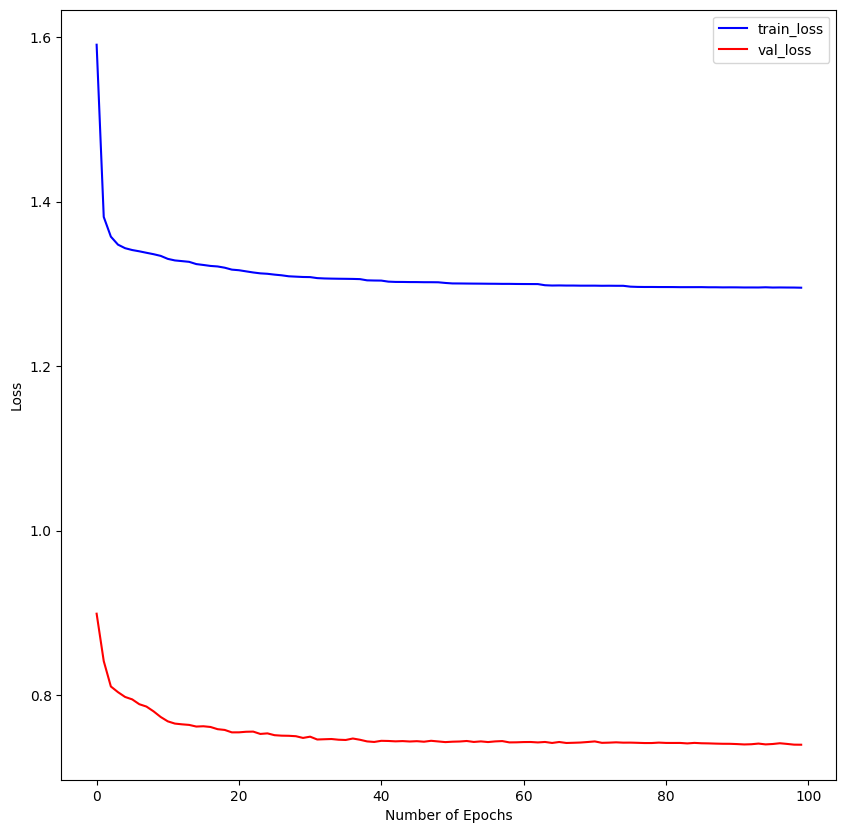

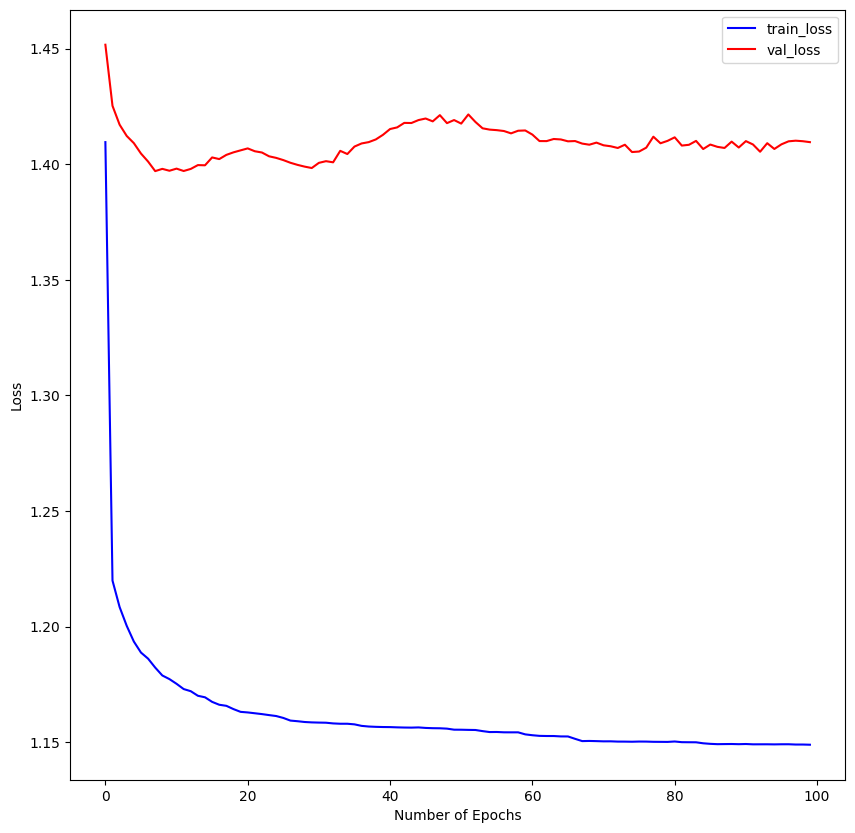

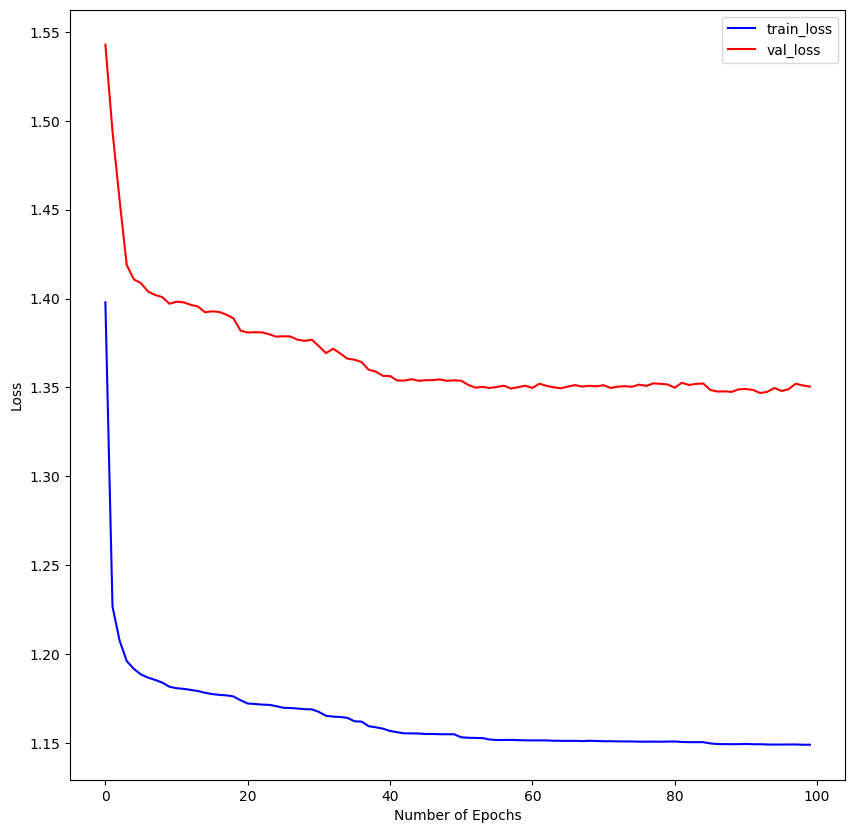

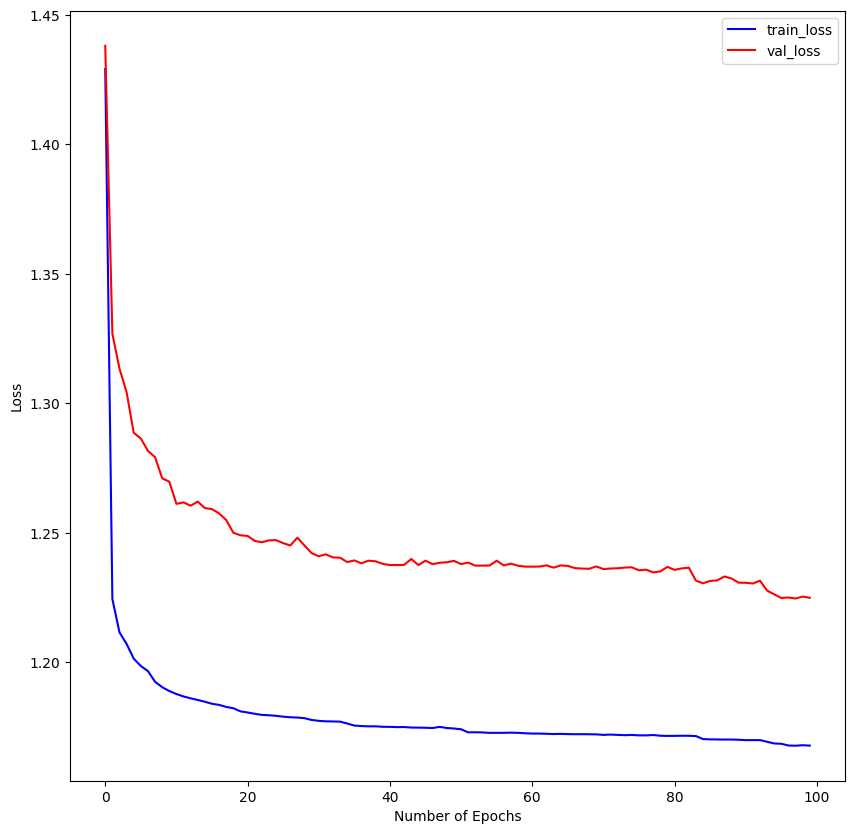

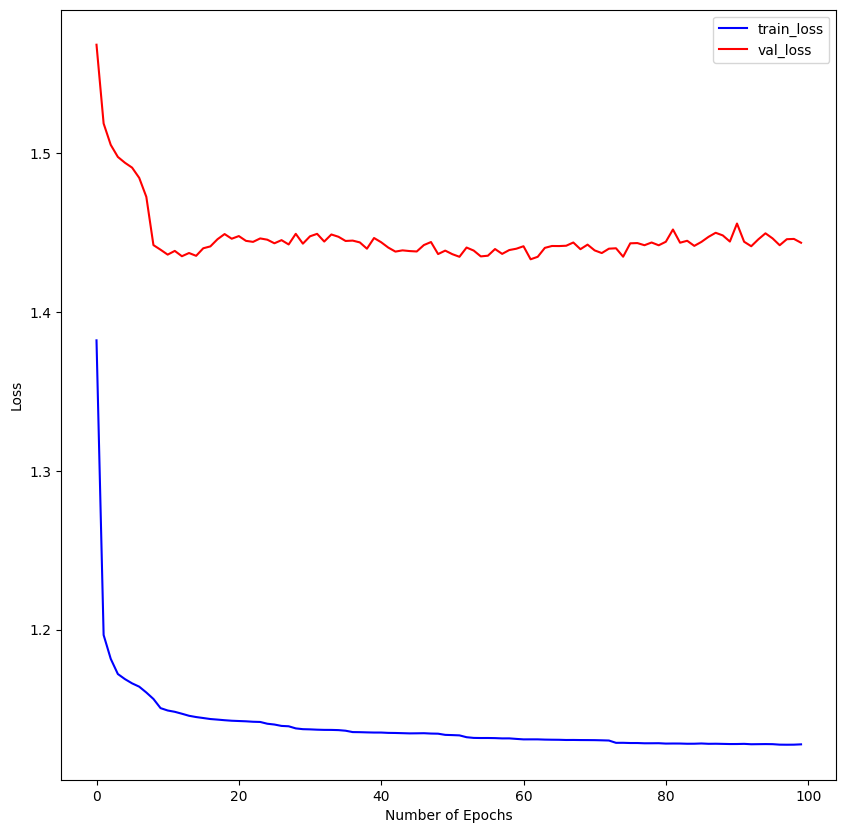

In [12]:
X1,X2=preprocess()
k="shallow"
path=f"/content/drive/MyDrive/X_stacked_autoencoder/{k}"
## training and saving the autoencoder:
train(path,X1,X2)
## Trying out classifiers:
training(path)